# Laponite Stress Relaxation

Fit one laponite relaxation curve; swap file to explore others.

**Data:** examples/data/pyRheo/laponite/rel_lapo_*.csv


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fractional_maxwell_model import FractionalMaxwellModel
from rheojax.models.generalized_maxwell import GeneralizedMaxwell
from rheojax.pipeline.base import Pipeline

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)

def load_tab_file(path):
    df = pd.read_csv(path, sep='	')
    df.columns = df.columns.str.strip()
    df = df.dropna()
    df.iloc[:,0] = pd.to_numeric(df.iloc[:,0], errors='coerce')
    df.iloc[:,1] = pd.to_numeric(df.iloc[:,1], errors='coerce')
    df = df.dropna()
    return df
import arviz as az


INFO:2025-12-07 17:46:37,114:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Loading rheojax version 0.4.0


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


Found 'auto' as default backend, checking available backends


Matplotlib is available, defining as default backend


arviz_base available, exposing its functions as part of arviz.preview


arviz_stats available, exposing its functions as part of arviz.preview


arviz_plots available, exposing its functions as part of arviz.preview


## Load multiple laponite curves

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'pyRheo' / 'laponite'
files = sorted(DATA_DIR.glob('rel_lapo_*.csv'))
frames = []
for f in files:
    df = load_tab_file(f)
    df['label'] = f.stem
    frames.append(df)
all_df = pd.concat(frames, ignore_index=True)
print(all_df.head())


       Time  Relaxation Modulus          label
0  0.290448          299.325342  rel_lapo_1200
1  0.591897          331.353202  rel_lapo_1200
2  0.959112          347.234241  rel_lapo_1200
3  1.420559          342.251848  rel_lapo_1200
4  1.999200          330.342952  rel_lapo_1200


## Fit one laponite curve (adjust label)

In [4]:
target = files[0]
df = load_tab_file(target)
t = df.iloc[:,0].to_numpy()
G = df.iloc[:,1].to_numpy()

gm = GeneralizedMaxwell(n_modes=5, modulus_type='tensile')
gm.fit(t, G, test_mode='relaxation', use_log_residuals=True, use_multi_start=True)
gm_pred = gm.predict(t)
gm_r2 = gm.score(t, G)

fm = FractionalMaxwellModel()
fm.fit(t, G, test_mode='relaxation', use_log_residuals=True)
fm_pred = fm.predict(t, test_mode='relaxation')
fm_r2 = r2_complex(G, fm_pred)

print({'gm_r2': gm_r2, 'fm_r2': fm_r2, 'file': target.name})


Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.233251s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=12 | final_cost=7.518359e+02 | time=1.233s | final_gradient_norm=2.718967702833095


Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.280138s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=12 | final_cost=7.518359e+02 | time=0.280s | final_gradient_norm=2.718967702833095


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.068428s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=7.518454e+02 | time=1.068s | final_gradient_norm=3.0716062927384002


Starting least squares optimization | {'method': 'trf', 'n_params': 7, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.925121s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=7 | final_cost=7.704727e+02 | time=0.925s | final_gradient_norm=9.086981593331787


Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.884132s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=1.441427e+03 | time=0.884s | final_gradient_norm=13496.622443203309


Element minimization: early termination at n_modes=2 (R²=0.948595 < threshold=0.959781)


Element minimization: reducing from 5 to 3 modes


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


[WARNING] Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Timer: optimization took 1.270576s


Convergence: reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=1.054542e+05 | time=1.271s | final_gradient_norm=nan


NLSQ hit inner iteration limit; retrying with SciPy least_squares for stability.


{'gm_r2': 0.9725228484511133, 'fm_r2': -367488.00467703235, 'file': 'rel_lapo_1200.csv'}


## Plot relaxation fits

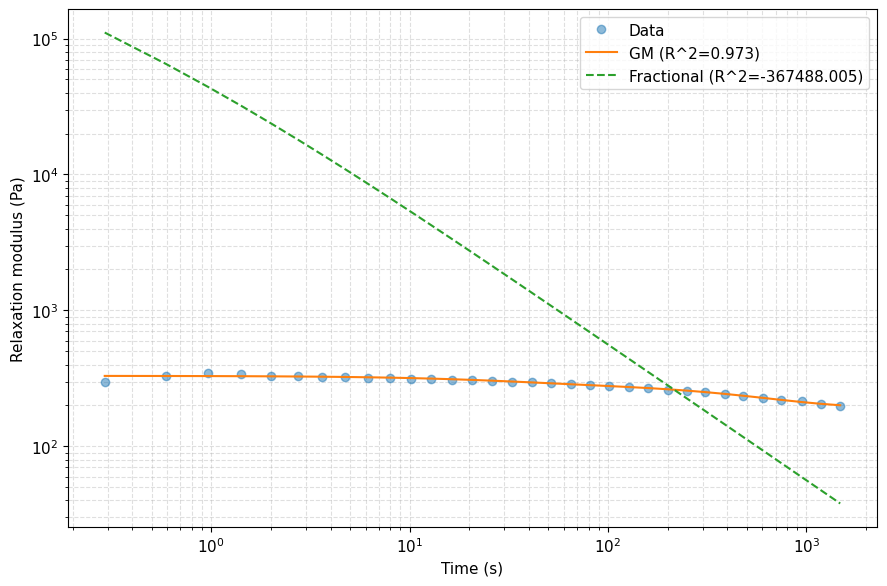

In [5]:
fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(t, G, 'o', label='Data', alpha=0.5)
ax.loglog(t, gm_pred, '-', label=f'GM (R^2={gm_r2:.3f})')
ax.loglog(t, fm_pred, '--', label=f'Fractional (R^2={fm_r2:.3f})')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Relaxation modulus (Pa)')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

Starting least squares optimization | {'method': 'trf', 'n_params': 7, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.348687s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=31 | final_cost=7.518454e+02 | time=0.349s | final_gradient_norm=116.06072098083293


Starting least squares optimization | {'method': 'trf', 'n_params': 7, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.332901s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=31 | final_cost=7.518454e+02 | time=0.333s | final_gradient_norm=116.06072098083293


Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.254954s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=7.704727e+02 | time=0.255s | final_gradient_norm=0.1682929372238546


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.620629s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=13 | final_cost=1.441426e+03 | time=0.621s | final_gradient_norm=0.3674525997815923


Element minimization: early termination at n_modes=1 (R²=0.948595 < threshold=0.959781)


Element minimization: reducing from 3 to 2 modes


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


[WARNING] Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Timer: optimization took 0.658911s


Convergence: reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=1.054542e+05 | time=0.659s | final_gradient_norm=nan


NLSQ hit inner iteration limit; retrying with SciPy least_squares for stability.


Model ranking (R²): [('gm', 0.973), ('fm', -367488.005)]


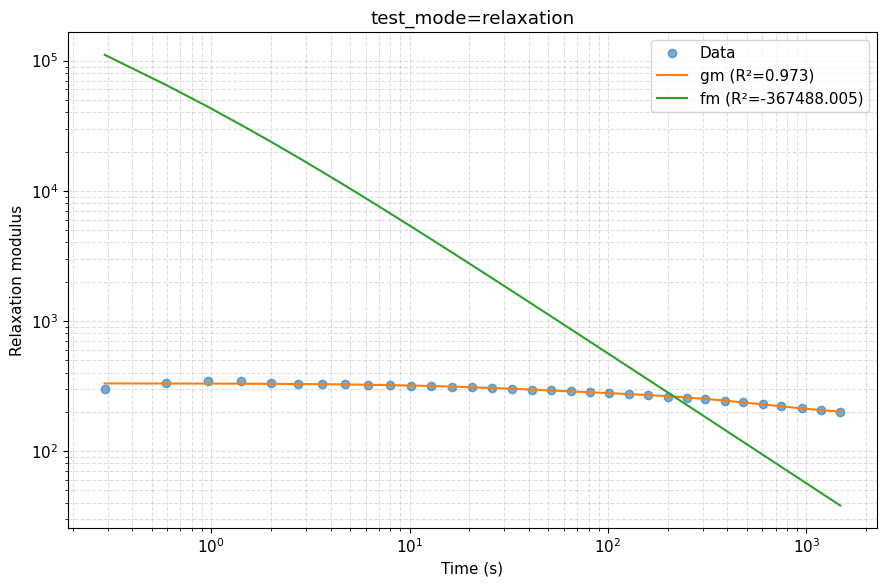

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:00<42:11,  1.58it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 42/4000 [00:00<00:51, 76.70it/s, 127 steps of size 8.25e-03. acc. prob=0.73]

warmup:   2%|▏         | 98/4000 [00:00<00:22, 176.14it/s, 575 steps of size 9.03e-03. acc. prob=0.76]

warmup:   4%|▎         | 141/4000 [00:00<00:16, 233.70it/s, 1023 steps of size 6.02e-03. acc. prob=0.77]

warmup:   5%|▍         | 181/4000 [00:01<00:15, 242.77it/s, 511 steps of size 9.98e-03. acc. prob=0.77] 

warmup:   5%|▌         | 216/4000 [00:01<00:16, 227.35it/s, 499 steps of size 8.73e-03. acc. prob=0.77]

warmup:   6%|▌         | 246/4000 [00:01<00:16, 227.75it/s, 127 steps of size 1.19e-02. acc. prob=0.78]

warmup:   7%|▋         | 274/4000 [00:01<00:16, 224.46it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:   8%|▊         | 300/4000 [00:01<00:16, 224.40it/s, 1023 steps of size 8.55e-03. acc. prob=0.78]

warmup:   8%|▊         | 325/4000 [00:01<00:16, 223.95it/s, 1023 steps of size 8.06e-03. acc. prob=0.78]

warmup:   9%|▉         | 361/4000 [00:01<00:14, 258.28it/s, 63 steps of size 2.88e-02. acc. prob=0.78]  

warmup:  10%|█         | 411/4000 [00:01<00:11, 321.71it/s, 127 steps of size 1.98e-02. acc. prob=0.78]

warmup:  11%|█▏        | 451/4000 [00:02<00:10, 342.65it/s, 31 steps of size 4.31e-02. acc. prob=0.78] 

warmup:  12%|█▏        | 487/4000 [00:02<00:11, 313.05it/s, 47 steps of size 5.07e-03. acc. prob=0.78]

warmup:  13%|█▎        | 523/4000 [00:02<00:10, 324.33it/s, 127 steps of size 3.44e-03. acc. prob=0.78]

warmup:  14%|█▍        | 557/4000 [00:02<00:11, 311.12it/s, 255 steps of size 1.03e-02. acc. prob=0.78]

warmup:  15%|█▌        | 607/4000 [00:02<00:09, 362.20it/s, 383 steps of size 9.12e-03. acc. prob=0.78]

warmup:  16%|█▋        | 656/4000 [00:02<00:08, 391.39it/s, 1023 steps of size 7.21e-03. acc. prob=0.79]

warmup:  17%|█▋        | 697/4000 [00:02<00:08, 392.25it/s, 127 steps of size 1.62e-02. acc. prob=0.79] 

warmup:  19%|█▊        | 749/4000 [00:02<00:07, 424.30it/s, 575 steps of size 1.33e-02. acc. prob=0.79]

warmup:  20%|█▉        | 795/4000 [00:02<00:07, 432.42it/s, 511 steps of size 1.30e-02. acc. prob=0.79]

warmup:  21%|██▏       | 855/4000 [00:03<00:06, 478.74it/s, 127 steps of size 1.76e-02. acc. prob=0.79]

warmup:  23%|██▎       | 904/4000 [00:03<00:06, 472.67it/s, 255 steps of size 1.71e-02. acc. prob=0.79]

warmup:  24%|██▍       | 958/4000 [00:03<00:06, 492.09it/s, 255 steps of size 3.47e-03. acc. prob=0.79]

sample:  25%|██▌       | 1008/4000 [00:03<00:06, 466.87it/s, 255 steps of size 1.35e-02. acc. prob=0.94]

sample:  26%|██▋       | 1058/4000 [00:03<00:06, 473.32it/s, 255 steps of size 1.35e-02. acc. prob=0.86]

sample:  28%|██▊       | 1106/4000 [00:03<00:06, 471.15it/s, 479 steps of size 1.35e-02. acc. prob=0.87]

sample:  29%|██▉       | 1154/4000 [00:03<00:06, 441.37it/s, 255 steps of size 1.35e-02. acc. prob=0.87]

sample:  30%|███       | 1200/4000 [00:03<00:06, 445.45it/s, 127 steps of size 1.35e-02. acc. prob=0.86]

sample:  31%|███▏      | 1259/4000 [00:03<00:05, 485.90it/s, 127 steps of size 1.35e-02. acc. prob=0.85]

sample:  33%|███▎      | 1317/4000 [00:03<00:05, 511.27it/s, 127 steps of size 1.35e-02. acc. prob=0.82]

sample:  34%|███▍      | 1369/4000 [00:04<00:05, 508.68it/s, 127 steps of size 1.35e-02. acc. prob=0.82]

sample:  36%|███▌      | 1423/4000 [00:04<00:04, 516.39it/s, 127 steps of size 1.35e-02. acc. prob=0.83]

sample:  37%|███▋      | 1477/4000 [00:04<00:04, 519.53it/s, 255 steps of size 1.35e-02. acc. prob=0.84]

sample:  38%|███▊      | 1530/4000 [00:04<00:04, 504.06it/s, 255 steps of size 1.35e-02. acc. prob=0.83]

sample:  40%|███▉      | 1585/4000 [00:04<00:04, 517.01it/s, 255 steps of size 1.35e-02. acc. prob=0.82]

sample:  41%|████      | 1646/4000 [00:04<00:04, 538.96it/s, 383 steps of size 1.35e-02. acc. prob=0.81]

sample:  43%|████▎     | 1701/4000 [00:04<00:04, 521.16it/s, 127 steps of size 1.35e-02. acc. prob=0.82]

sample:  44%|████▍     | 1758/4000 [00:04<00:04, 534.08it/s, 255 steps of size 1.35e-02. acc. prob=0.81]

sample:  45%|████▌     | 1814/4000 [00:04<00:04, 541.13it/s, 127 steps of size 1.35e-02. acc. prob=0.82]

sample:  47%|████▋     | 1869/4000 [00:05<00:03, 534.80it/s, 255 steps of size 1.35e-02. acc. prob=0.82]

sample:  48%|████▊     | 1923/4000 [00:05<00:04, 502.24it/s, 63 steps of size 1.35e-02. acc. prob=0.82] 

sample:  49%|████▉     | 1978/4000 [00:05<00:03, 510.82it/s, 255 steps of size 1.35e-02. acc. prob=0.82]

sample:  51%|█████     | 2033/4000 [00:05<00:03, 521.30it/s, 97 steps of size 1.35e-02. acc. prob=0.82] 

sample:  52%|█████▏    | 2086/4000 [00:05<00:03, 503.17it/s, 223 steps of size 1.35e-02. acc. prob=0.82]

sample:  54%|█████▍    | 2153/4000 [00:05<00:03, 549.69it/s, 46 steps of size 1.35e-02. acc. prob=0.80] 

sample:  55%|█████▌    | 2212/4000 [00:05<00:03, 561.10it/s, 255 steps of size 1.35e-02. acc. prob=0.79]

sample:  57%|█████▋    | 2272/4000 [00:05<00:03, 568.94it/s, 255 steps of size 1.35e-02. acc. prob=0.79]

sample:  58%|█████▊    | 2330/4000 [00:05<00:02, 561.21it/s, 15 steps of size 1.35e-02. acc. prob=0.79] 

sample:  60%|█████▉    | 2388/4000 [00:05<00:02, 564.82it/s, 127 steps of size 1.35e-02. acc. prob=0.79]

sample:  61%|██████    | 2445/4000 [00:06<00:02, 561.26it/s, 191 steps of size 1.35e-02. acc. prob=0.79]

sample:  63%|██████▎   | 2507/4000 [00:06<00:02, 576.20it/s, 127 steps of size 1.35e-02. acc. prob=0.79]

sample:  64%|██████▍   | 2565/4000 [00:06<00:02, 551.54it/s, 191 steps of size 1.35e-02. acc. prob=0.79]

sample:  66%|██████▌   | 2621/4000 [00:06<00:02, 538.83it/s, 365 steps of size 1.35e-02. acc. prob=0.79]

sample:  67%|██████▋   | 2676/4000 [00:06<00:02, 533.04it/s, 255 steps of size 1.35e-02. acc. prob=0.79]

sample:  68%|██████▊   | 2730/4000 [00:06<00:02, 521.76it/s, 255 steps of size 1.35e-02. acc. prob=0.79]

sample:  70%|██████▉   | 2783/4000 [00:06<00:02, 515.11it/s, 255 steps of size 1.35e-02. acc. prob=0.80]

sample:  71%|███████   | 2835/4000 [00:06<00:02, 511.46it/s, 63 steps of size 1.35e-02. acc. prob=0.80] 

sample:  72%|███████▏  | 2892/4000 [00:06<00:02, 527.96it/s, 255 steps of size 1.35e-02. acc. prob=0.80]

sample:  74%|███████▍  | 2950/4000 [00:07<00:01, 539.87it/s, 223 steps of size 1.35e-02. acc. prob=0.80]

sample:  75%|███████▌  | 3005/4000 [00:07<00:01, 526.30it/s, 255 steps of size 1.35e-02. acc. prob=0.81]

sample:  76%|███████▋  | 3058/4000 [00:07<00:01, 522.85it/s, 127 steps of size 1.35e-02. acc. prob=0.81]

sample:  78%|███████▊  | 3111/4000 [00:07<00:01, 510.78it/s, 215 steps of size 1.35e-02. acc. prob=0.81]

sample:  79%|███████▉  | 3163/4000 [00:07<00:01, 511.56it/s, 255 steps of size 1.35e-02. acc. prob=0.81]

sample:  81%|████████  | 3221/4000 [00:07<00:01, 531.27it/s, 159 steps of size 1.35e-02. acc. prob=0.81]

sample:  82%|████████▏ | 3275/4000 [00:07<00:01, 532.88it/s, 87 steps of size 1.35e-02. acc. prob=0.81] 

sample:  83%|████████▎ | 3339/4000 [00:07<00:01, 562.81it/s, 127 steps of size 1.35e-02. acc. prob=0.80]

sample:  85%|████████▍ | 3396/4000 [00:07<00:01, 528.64it/s, 44 steps of size 1.35e-02. acc. prob=0.80] 

sample:  86%|████████▋ | 3450/4000 [00:08<00:01, 511.85it/s, 127 steps of size 1.35e-02. acc. prob=0.80]

sample:  88%|████████▊ | 3505/4000 [00:08<00:00, 518.83it/s, 255 steps of size 1.35e-02. acc. prob=0.80]

sample:  89%|████████▉ | 3558/4000 [00:08<00:00, 509.82it/s, 63 steps of size 1.35e-02. acc. prob=0.81] 

sample:  90%|█████████ | 3610/4000 [00:08<00:00, 511.43it/s, 127 steps of size 1.35e-02. acc. prob=0.81]

sample:  92%|█████████▏| 3662/4000 [00:08<00:00, 502.14it/s, 127 steps of size 1.35e-02. acc. prob=0.81]

sample:  93%|█████████▎| 3713/4000 [00:08<00:00, 492.14it/s, 255 steps of size 1.35e-02. acc. prob=0.81]

sample:  94%|█████████▍| 3764/4000 [00:08<00:00, 496.50it/s, 115 steps of size 1.35e-02. acc. prob=0.81]

sample:  95%|█████████▌| 3814/4000 [00:08<00:00, 477.33it/s, 47 steps of size 1.35e-02. acc. prob=0.81] 

sample:  97%|█████████▋| 3862/4000 [00:08<00:00, 452.06it/s, 43 steps of size 1.35e-02. acc. prob=0.81]

sample:  98%|█████████▊| 3925/4000 [00:08<00:00, 498.76it/s, 255 steps of size 1.35e-02. acc. prob=0.81]

sample: 100%|█████████▉| 3980/4000 [00:09<00:00, 511.26it/s, 127 steps of size 1.35e-02. acc. prob=0.81]

sample: 100%|██████████| 4000/4000 [00:09<00:00, 438.72it/s, 127 steps of size 1.35e-02. acc. prob=0.81]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|▏         | 51/4000 [00:00<00:07, 501.27it/s, 223 steps of size 1.26e-02. acc. prob=0.74]

warmup:   3%|▎         | 102/4000 [00:00<00:09, 401.71it/s, 1 steps of size 2.97e-02. acc. prob=0.76] 

warmup:   4%|▎         | 144/4000 [00:00<00:13, 289.80it/s, 309 steps of size 5.29e-03. acc. prob=0.77]

warmup:   4%|▍         | 176/4000 [00:00<00:13, 273.34it/s, 2 steps of size 2.87e-03. acc. prob=0.77]  

warmup:   5%|▌         | 210/4000 [00:00<00:13, 291.16it/s, 55 steps of size 2.06e-02. acc. prob=0.77]

warmup:   6%|▋         | 254/4000 [00:00<00:11, 331.11it/s, 511 steps of size 1.38e-02. acc. prob=0.77]

warmup:   7%|▋         | 289/4000 [00:00<00:11, 315.85it/s, 383 steps of size 7.79e-03. acc. prob=0.78]

warmup:   8%|▊         | 322/4000 [00:01<00:12, 301.38it/s, 191 steps of size 3.70e-02. acc. prob=0.78]

warmup:   9%|▉         | 358/4000 [00:01<00:11, 314.74it/s, 767 steps of size 9.03e-03. acc. prob=0.78]

warmup:  10%|█         | 402/4000 [00:01<00:10, 348.59it/s, 127 steps of size 1.27e-02. acc. prob=0.78]

warmup:  11%|█         | 447/4000 [00:01<00:09, 376.98it/s, 63 steps of size 8.71e-03. acc. prob=0.78] 

warmup:  12%|█▏        | 486/4000 [00:01<00:09, 376.75it/s, 1023 steps of size 5.94e-03. acc. prob=0.78]

warmup:  13%|█▎        | 525/4000 [00:01<00:09, 352.59it/s, 639 steps of size 1.41e-02. acc. prob=0.78] 

warmup:  14%|█▍        | 563/4000 [00:01<00:09, 357.96it/s, 255 steps of size 1.98e-02. acc. prob=0.78]

warmup:  15%|█▌        | 609/4000 [00:01<00:08, 383.37it/s, 255 steps of size 7.64e-03. acc. prob=0.78]

warmup:  16%|█▋        | 654/4000 [00:01<00:08, 402.11it/s, 191 steps of size 1.30e-02. acc. prob=0.79]

warmup:  18%|█▊        | 704/4000 [00:01<00:07, 428.63it/s, 127 steps of size 1.35e-02. acc. prob=0.79]

warmup:  19%|█▉        | 758/4000 [00:02<00:07, 460.57it/s, 111 steps of size 1.78e-02. acc. prob=0.79]

warmup:  21%|██        | 821/4000 [00:02<00:06, 507.97it/s, 255 steps of size 1.38e-02. acc. prob=0.79]

warmup:  22%|██▏       | 885/4000 [00:02<00:05, 543.98it/s, 255 steps of size 1.19e-02. acc. prob=0.79]

warmup:  24%|██▎       | 940/4000 [00:02<00:06, 501.38it/s, 255 steps of size 1.49e-02. acc. prob=0.79]

warmup:  25%|██▍       | 991/4000 [00:02<00:07, 404.88it/s, 511 steps of size 6.29e-03. acc. prob=0.79]

sample:  26%|██▌       | 1035/4000 [00:02<00:07, 372.46it/s, 1023 steps of size 8.75e-03. acc. prob=0.94]

sample:  27%|██▋       | 1075/4000 [00:02<00:07, 366.17it/s, 63 steps of size 8.75e-03. acc. prob=0.95]  

sample:  28%|██▊       | 1114/4000 [00:02<00:08, 338.35it/s, 511 steps of size 8.75e-03. acc. prob=0.95]

sample:  29%|██▉       | 1150/4000 [00:03<00:08, 336.31it/s, 127 steps of size 8.75e-03. acc. prob=0.94]

sample:  30%|██▉       | 1187/4000 [00:03<00:08, 342.45it/s, 511 steps of size 8.75e-03. acc. prob=0.93]

sample:  31%|███       | 1225/4000 [00:03<00:07, 350.56it/s, 255 steps of size 8.75e-03. acc. prob=0.92]

sample:  32%|███▏      | 1261/4000 [00:03<00:07, 344.03it/s, 255 steps of size 8.75e-03. acc. prob=0.92]

sample:  33%|███▎      | 1303/4000 [00:03<00:07, 361.38it/s, 511 steps of size 8.75e-03. acc. prob=0.91]

sample:  34%|███▎      | 1347/4000 [00:03<00:06, 380.22it/s, 255 steps of size 8.75e-03. acc. prob=0.92]

sample:  35%|███▍      | 1386/4000 [00:03<00:07, 369.18it/s, 255 steps of size 8.75e-03. acc. prob=0.92]

sample:  36%|███▌      | 1424/4000 [00:03<00:06, 370.36it/s, 255 steps of size 8.75e-03. acc. prob=0.92]

sample:  37%|███▋      | 1466/4000 [00:03<00:06, 383.18it/s, 127 steps of size 8.75e-03. acc. prob=0.92]

sample:  38%|███▊      | 1506/4000 [00:04<00:06, 387.94it/s, 255 steps of size 8.75e-03. acc. prob=0.92]

sample:  39%|███▊      | 1545/4000 [00:04<00:06, 375.20it/s, 223 steps of size 8.75e-03. acc. prob=0.92]

sample:  40%|███▉      | 1583/4000 [00:04<00:06, 365.10it/s, 255 steps of size 8.75e-03. acc. prob=0.92]

sample:  40%|████      | 1620/4000 [00:04<00:06, 360.93it/s, 319 steps of size 8.75e-03. acc. prob=0.92]

sample:  41%|████▏     | 1657/4000 [00:04<00:07, 319.92it/s, 255 steps of size 8.75e-03. acc. prob=0.92]

sample:  42%|████▏     | 1694/4000 [00:04<00:06, 332.73it/s, 127 steps of size 8.75e-03. acc. prob=0.92]

sample:  43%|████▎     | 1733/4000 [00:04<00:06, 348.37it/s, 127 steps of size 8.75e-03. acc. prob=0.92]

sample:  44%|████▍     | 1769/4000 [00:04<00:06, 332.32it/s, 151 steps of size 8.75e-03. acc. prob=0.93]

sample:  45%|████▌     | 1811/4000 [00:04<00:06, 355.08it/s, 207 steps of size 8.75e-03. acc. prob=0.92]

sample:  46%|████▋     | 1851/4000 [00:05<00:05, 359.82it/s, 767 steps of size 8.75e-03. acc. prob=0.93]

sample:  47%|████▋     | 1888/4000 [00:05<00:05, 352.90it/s, 191 steps of size 8.75e-03. acc. prob=0.93]

sample:  48%|████▊     | 1924/4000 [00:05<00:05, 349.54it/s, 23 steps of size 8.75e-03. acc. prob=0.93] 

sample:  49%|████▉     | 1960/4000 [00:05<00:05, 347.53it/s, 7 steps of size 8.75e-03. acc. prob=0.93] 

sample:  50%|████▉     | 1997/4000 [00:05<00:05, 351.42it/s, 255 steps of size 8.75e-03. acc. prob=0.93]

sample:  51%|█████     | 2033/4000 [00:05<00:05, 348.38it/s, 511 steps of size 8.75e-03. acc. prob=0.93]

sample:  52%|█████▏    | 2068/4000 [00:05<00:05, 332.84it/s, 255 steps of size 8.75e-03. acc. prob=0.93]

sample:  53%|█████▎    | 2102/4000 [00:05<00:05, 327.22it/s, 191 steps of size 8.75e-03. acc. prob=0.93]

sample:  53%|█████▎    | 2135/4000 [00:05<00:05, 319.91it/s, 255 steps of size 8.75e-03. acc. prob=0.93]

sample:  54%|█████▍    | 2172/4000 [00:06<00:05, 333.50it/s, 159 steps of size 8.75e-03. acc. prob=0.93]

sample:  55%|█████▌    | 2210/4000 [00:06<00:05, 343.18it/s, 383 steps of size 8.75e-03. acc. prob=0.93]

sample:  56%|█████▋    | 2254/4000 [00:06<00:04, 370.59it/s, 31 steps of size 8.75e-03. acc. prob=0.93] 

sample:  57%|█████▋    | 2292/4000 [00:06<00:04, 349.39it/s, 127 steps of size 8.75e-03. acc. prob=0.93]

sample:  58%|█████▊    | 2336/4000 [00:06<00:04, 373.71it/s, 127 steps of size 8.75e-03. acc. prob=0.93]

sample:  59%|█████▉    | 2379/4000 [00:06<00:04, 389.23it/s, 23 steps of size 8.75e-03. acc. prob=0.93] 

sample:  60%|██████    | 2420/4000 [00:06<00:04, 393.77it/s, 191 steps of size 8.75e-03. acc. prob=0.93]

sample:  62%|██████▏   | 2460/4000 [00:06<00:04, 370.26it/s, 767 steps of size 8.75e-03. acc. prob=0.93]

sample:  62%|██████▏   | 2498/4000 [00:06<00:04, 368.50it/s, 63 steps of size 8.75e-03. acc. prob=0.93] 

sample:  63%|██████▎   | 2536/4000 [00:06<00:04, 364.65it/s, 447 steps of size 8.75e-03. acc. prob=0.93]

sample:  64%|██████▍   | 2573/4000 [00:07<00:03, 360.27it/s, 255 steps of size 8.75e-03. acc. prob=0.93]

sample:  65%|██████▌   | 2616/4000 [00:07<00:03, 377.42it/s, 255 steps of size 8.75e-03. acc. prob=0.93]

sample:  66%|██████▋   | 2658/4000 [00:07<00:03, 389.04it/s, 31 steps of size 8.75e-03. acc. prob=0.93] 

sample:  68%|██████▊   | 2700/4000 [00:07<00:03, 396.63it/s, 255 steps of size 8.75e-03. acc. prob=0.93]

sample:  68%|██████▊   | 2740/4000 [00:07<00:03, 374.68it/s, 383 steps of size 8.75e-03. acc. prob=0.93]

sample:  69%|██████▉   | 2779/4000 [00:07<00:03, 377.61it/s, 255 steps of size 8.75e-03. acc. prob=0.93]

sample:  70%|███████   | 2817/4000 [00:07<00:03, 358.54it/s, 511 steps of size 8.75e-03. acc. prob=0.93]

sample:  71%|███████▏  | 2854/4000 [00:07<00:03, 350.36it/s, 511 steps of size 8.75e-03. acc. prob=0.93]

sample:  72%|███████▏  | 2890/4000 [00:07<00:03, 329.52it/s, 191 steps of size 8.75e-03. acc. prob=0.93]

sample:  73%|███████▎  | 2924/4000 [00:08<00:03, 324.95it/s, 127 steps of size 8.75e-03. acc. prob=0.93]

sample:  74%|███████▍  | 2965/4000 [00:08<00:02, 346.49it/s, 255 steps of size 8.75e-03. acc. prob=0.93]

sample:  75%|███████▌  | 3002/4000 [00:08<00:02, 351.82it/s, 383 steps of size 8.75e-03. acc. prob=0.93]

sample:  76%|███████▌  | 3038/4000 [00:08<00:02, 351.41it/s, 255 steps of size 8.75e-03. acc. prob=0.93]

sample:  77%|███████▋  | 3074/4000 [00:08<00:02, 338.55it/s, 319 steps of size 8.75e-03. acc. prob=0.93]

sample:  78%|███████▊  | 3109/4000 [00:08<00:02, 327.06it/s, 7 steps of size 8.75e-03. acc. prob=0.93]  

sample:  79%|███████▊  | 3142/4000 [00:08<00:02, 324.67it/s, 127 steps of size 8.75e-03. acc. prob=0.93]

sample:  79%|███████▉  | 3175/4000 [00:08<00:02, 324.55it/s, 63 steps of size 8.75e-03. acc. prob=0.93] 

sample:  80%|████████  | 3208/4000 [00:08<00:02, 324.99it/s, 63 steps of size 8.75e-03. acc. prob=0.93]

sample:  81%|████████  | 3245/4000 [00:09<00:02, 338.00it/s, 383 steps of size 8.75e-03. acc. prob=0.93]

sample:  82%|████████▏ | 3286/4000 [00:09<00:02, 356.72it/s, 383 steps of size 8.75e-03. acc. prob=0.93]

sample:  83%|████████▎ | 3323/4000 [00:09<00:01, 358.21it/s, 255 steps of size 8.75e-03. acc. prob=0.93]

sample:  84%|████████▍ | 3361/4000 [00:09<00:01, 363.93it/s, 255 steps of size 8.75e-03. acc. prob=0.93]

sample:  85%|████████▍ | 3398/4000 [00:09<00:01, 360.41it/s, 447 steps of size 8.75e-03. acc. prob=0.93]

sample:  86%|████████▌ | 3435/4000 [00:09<00:01, 339.24it/s, 191 steps of size 8.75e-03. acc. prob=0.93]

sample:  87%|████████▋ | 3473/4000 [00:09<00:01, 344.61it/s, 511 steps of size 8.75e-03. acc. prob=0.93]

sample:  88%|████████▊ | 3508/4000 [00:09<00:01, 340.62it/s, 255 steps of size 8.75e-03. acc. prob=0.93]

sample:  89%|████████▊ | 3543/4000 [00:09<00:01, 333.01it/s, 383 steps of size 8.75e-03. acc. prob=0.93]

sample:  89%|████████▉ | 3577/4000 [00:09<00:01, 317.14it/s, 255 steps of size 8.75e-03. acc. prob=0.93]

sample:  90%|█████████ | 3612/4000 [00:10<00:01, 325.26it/s, 383 steps of size 8.75e-03. acc. prob=0.93]

sample:  91%|█████████ | 3645/4000 [00:10<00:01, 292.55it/s, 287 steps of size 8.75e-03. acc. prob=0.94]

sample:  92%|█████████▏| 3688/4000 [00:10<00:00, 326.93it/s, 255 steps of size 8.75e-03. acc. prob=0.94]

sample:  93%|█████████▎| 3727/4000 [00:10<00:00, 343.95it/s, 111 steps of size 8.75e-03. acc. prob=0.94]

sample:  94%|█████████▍| 3764/4000 [00:10<00:00, 351.03it/s, 383 steps of size 8.75e-03. acc. prob=0.94]

sample:  95%|█████████▌| 3800/4000 [00:10<00:00, 331.99it/s, 767 steps of size 8.75e-03. acc. prob=0.94]

sample:  96%|█████████▌| 3838/4000 [00:10<00:00, 344.34it/s, 127 steps of size 8.75e-03. acc. prob=0.94]

sample:  97%|█████████▋| 3878/4000 [00:10<00:00, 358.98it/s, 383 steps of size 8.75e-03. acc. prob=0.94]

sample:  98%|█████████▊| 3915/4000 [00:10<00:00, 333.14it/s, 225 steps of size 8.75e-03. acc. prob=0.94]

sample:  99%|█████████▉| 3950/4000 [00:11<00:00, 337.19it/s, 271 steps of size 8.75e-03. acc. prob=0.94]

sample: 100%|█████████▉| 3988/4000 [00:11<00:00, 346.42it/s, 767 steps of size 8.75e-03. acc. prob=0.94]

sample: 100%|██████████| 4000/4000 [00:11<00:00, 356.04it/s, 511 steps of size 8.75e-03. acc. prob=0.94]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|          | 49/4000 [00:00<00:08, 479.39it/s, 255 steps of size 1.10e-02. acc. prob=0.74]

warmup:   2%|▏         | 97/4000 [00:00<00:08, 471.54it/s, 191 steps of size 7.33e-03. acc. prob=0.76]

warmup:   4%|▎         | 145/4000 [00:00<00:08, 460.19it/s, 255 steps of size 2.87e-02. acc. prob=0.77]

warmup:   5%|▍         | 192/4000 [00:00<00:10, 349.37it/s, 7 steps of size 6.27e-03. acc. prob=0.77]  

warmup:   6%|▌         | 230/4000 [00:00<00:10, 357.62it/s, 63 steps of size 2.46e-02. acc. prob=0.78]

warmup:   7%|▋         | 283/4000 [00:00<00:09, 403.84it/s, 511 steps of size 6.58e-03. acc. prob=0.78]

warmup:   8%|▊         | 326/4000 [00:00<00:08, 411.02it/s, 127 steps of size 1.91e-02. acc. prob=0.78]

warmup:   9%|▉         | 377/4000 [00:00<00:08, 439.14it/s, 79 steps of size 1.49e-02. acc. prob=0.78] 

warmup:  11%|█         | 427/4000 [00:01<00:07, 456.84it/s, 77 steps of size 1.30e-02. acc. prob=0.78]

warmup:  12%|█▏        | 474/4000 [00:01<00:07, 447.03it/s, 127 steps of size 4.03e-03. acc. prob=0.78]

warmup:  13%|█▎        | 520/4000 [00:01<00:08, 399.00it/s, 255 steps of size 8.68e-03. acc. prob=0.78]

warmup:  14%|█▍        | 562/4000 [00:01<00:08, 395.63it/s, 119 steps of size 2.58e-02. acc. prob=0.78]

warmup:  15%|█▌        | 617/4000 [00:01<00:07, 437.32it/s, 127 steps of size 2.01e-02. acc. prob=0.79]

warmup:  17%|█▋        | 672/4000 [00:01<00:07, 468.37it/s, 383 steps of size 1.42e-02. acc. prob=0.79]

warmup:  18%|█▊        | 728/4000 [00:01<00:06, 493.92it/s, 95 steps of size 1.11e-02. acc. prob=0.79] 

warmup:  20%|█▉        | 788/4000 [00:01<00:06, 523.66it/s, 127 steps of size 1.53e-02. acc. prob=0.79]

warmup:  21%|██▏       | 852/4000 [00:01<00:05, 552.54it/s, 511 steps of size 1.47e-02. acc. prob=0.79]

warmup:  23%|██▎       | 908/4000 [00:01<00:05, 544.91it/s, 63 steps of size 1.83e-02. acc. prob=0.79] 

warmup:  24%|██▍       | 963/4000 [00:02<00:05, 515.24it/s, 511 steps of size 6.60e-03. acc. prob=0.79]

sample:  25%|██▌       | 1016/4000 [00:02<00:06, 471.88it/s, 95 steps of size 1.45e-02. acc. prob=0.92]

sample:  27%|██▋       | 1066/4000 [00:02<00:06, 477.83it/s, 171 steps of size 1.45e-02. acc. prob=0.92]

sample:  28%|██▊       | 1118/4000 [00:02<00:05, 488.97it/s, 63 steps of size 1.45e-02. acc. prob=0.89] 

sample:  29%|██▉       | 1169/4000 [00:02<00:05, 494.54it/s, 63 steps of size 1.45e-02. acc. prob=0.90]

sample:  31%|███       | 1224/4000 [00:02<00:05, 508.47it/s, 255 steps of size 1.45e-02. acc. prob=0.89]

sample:  32%|███▏      | 1281/4000 [00:02<00:05, 522.57it/s, 255 steps of size 1.45e-02. acc. prob=0.88]

sample:  34%|███▎      | 1342/4000 [00:02<00:04, 547.29it/s, 127 steps of size 1.45e-02. acc. prob=0.83]

sample:  35%|███▍      | 1397/4000 [00:02<00:04, 542.90it/s, 255 steps of size 1.45e-02. acc. prob=0.83]

sample:  36%|███▋      | 1452/4000 [00:03<00:04, 523.17it/s, 127 steps of size 1.45e-02. acc. prob=0.84]

sample:  38%|███▊      | 1505/4000 [00:03<00:04, 510.91it/s, 63 steps of size 1.45e-02. acc. prob=0.84] 

sample:  39%|███▉      | 1557/4000 [00:03<00:04, 506.73it/s, 127 steps of size 1.45e-02. acc. prob=0.84]

sample:  40%|████      | 1608/4000 [00:03<00:04, 502.10it/s, 255 steps of size 1.45e-02. acc. prob=0.85]

sample:  41%|████▏     | 1659/4000 [00:03<00:04, 489.35it/s, 127 steps of size 1.45e-02. acc. prob=0.85]

sample:  43%|████▎     | 1709/4000 [00:03<00:04, 483.12it/s, 127 steps of size 1.45e-02. acc. prob=0.85]

sample:  44%|████▍     | 1780/4000 [00:03<00:04, 546.03it/s, 223 steps of size 1.45e-02. acc. prob=0.83]

sample:  46%|████▌     | 1835/4000 [00:03<00:04, 527.02it/s, 255 steps of size 1.45e-02. acc. prob=0.83]

sample:  47%|████▋     | 1889/4000 [00:03<00:03, 530.21it/s, 127 steps of size 1.45e-02. acc. prob=0.83]

sample:  49%|████▊     | 1946/4000 [00:04<00:03, 538.05it/s, 255 steps of size 1.45e-02. acc. prob=0.83]

sample:  50%|█████     | 2000/4000 [00:04<00:03, 507.80it/s, 271 steps of size 1.45e-02. acc. prob=0.84]

sample:  51%|█████▏    | 2052/4000 [00:04<00:03, 496.80it/s, 15 steps of size 1.45e-02. acc. prob=0.84] 

sample:  53%|█████▎    | 2107/4000 [00:04<00:03, 505.87it/s, 511 steps of size 1.45e-02. acc. prob=0.84]

sample:  54%|█████▍    | 2158/4000 [00:04<00:03, 505.18it/s, 127 steps of size 1.45e-02. acc. prob=0.84]

sample:  55%|█████▌    | 2211/4000 [00:04<00:03, 510.02it/s, 255 steps of size 1.45e-02. acc. prob=0.84]

sample:  58%|█████▊    | 2339/4000 [00:04<00:02, 731.01it/s, 127 steps of size 1.45e-02. acc. prob=0.78]

sample:  60%|██████    | 2413/4000 [00:04<00:02, 630.93it/s, 127 steps of size 1.45e-02. acc. prob=0.78]

sample:  62%|██████▏   | 2479/4000 [00:04<00:02, 575.17it/s, 383 steps of size 1.45e-02. acc. prob=0.79]

sample:  64%|██████▎   | 2540/4000 [00:05<00:02, 543.33it/s, 319 steps of size 1.45e-02. acc. prob=0.79]

sample:  65%|██████▍   | 2597/4000 [00:05<00:02, 532.04it/s, 11 steps of size 1.45e-02. acc. prob=0.79] 

sample:  66%|██████▋   | 2652/4000 [00:05<00:02, 515.55it/s, 159 steps of size 1.45e-02. acc. prob=0.79]

sample:  68%|██████▊   | 2712/4000 [00:05<00:02, 536.36it/s, 127 steps of size 1.45e-02. acc. prob=0.79]

sample:  69%|██████▉   | 2770/4000 [00:05<00:02, 546.80it/s, 127 steps of size 1.45e-02. acc. prob=0.79]

sample:  71%|███████   | 2830/4000 [00:05<00:02, 560.40it/s, 203 steps of size 1.45e-02. acc. prob=0.79]

sample:  72%|███████▏  | 2890/4000 [00:05<00:01, 570.72it/s, 127 steps of size 1.45e-02. acc. prob=0.79]

sample:  74%|███████▎  | 2948/4000 [00:05<00:01, 552.13it/s, 63 steps of size 1.45e-02. acc. prob=0.79] 

sample:  75%|███████▌  | 3004/4000 [00:05<00:01, 511.18it/s, 255 steps of size 1.45e-02. acc. prob=0.80]

sample:  76%|███████▋  | 3056/4000 [00:06<00:01, 496.57it/s, 511 steps of size 1.45e-02. acc. prob=0.80]

sample:  78%|███████▊  | 3108/4000 [00:06<00:01, 501.18it/s, 255 steps of size 1.45e-02. acc. prob=0.80]

sample:  79%|███████▉  | 3159/4000 [00:06<00:01, 467.63it/s, 255 steps of size 1.45e-02. acc. prob=0.80]

sample:  80%|████████  | 3214/4000 [00:06<00:01, 489.38it/s, 63 steps of size 1.45e-02. acc. prob=0.80] 

sample:  82%|████████▏ | 3266/4000 [00:06<00:01, 497.05it/s, 191 steps of size 1.45e-02. acc. prob=0.80]

sample:  83%|████████▎ | 3317/4000 [00:06<00:01, 496.74it/s, 319 steps of size 1.45e-02. acc. prob=0.81]

sample:  84%|████████▍ | 3368/4000 [00:06<00:01, 498.71it/s, 255 steps of size 1.45e-02. acc. prob=0.81]

sample:  85%|████████▌ | 3419/4000 [00:06<00:01, 494.99it/s, 107 steps of size 1.45e-02. acc. prob=0.81]

sample:  87%|████████▋ | 3476/4000 [00:06<00:01, 515.81it/s, 255 steps of size 1.45e-02. acc. prob=0.81]

sample:  88%|████████▊ | 3528/4000 [00:07<00:00, 490.23it/s, 223 steps of size 1.45e-02. acc. prob=0.81]

sample:  89%|████████▉ | 3578/4000 [00:07<00:00, 482.54it/s, 415 steps of size 1.45e-02. acc. prob=0.81]

sample:  91%|█████████ | 3630/4000 [00:07<00:00, 492.13it/s, 191 steps of size 1.45e-02. acc. prob=0.81]

sample:  92%|█████████▏| 3687/4000 [00:07<00:00, 512.11it/s, 191 steps of size 1.45e-02. acc. prob=0.81]

sample:  94%|█████████▎| 3744/4000 [00:07<00:00, 524.83it/s, 511 steps of size 1.45e-02. acc. prob=0.81]

sample:  95%|█████████▍| 3797/4000 [00:07<00:00, 483.86it/s, 511 steps of size 1.45e-02. acc. prob=0.82]

sample:  96%|█████████▌| 3847/4000 [00:07<00:00, 453.16it/s, 383 steps of size 1.45e-02. acc. prob=0.82]

sample:  98%|█████████▊| 3901/4000 [00:07<00:00, 475.17it/s, 255 steps of size 1.45e-02. acc. prob=0.82]

sample:  99%|█████████▉| 3950/4000 [00:07<00:00, 479.16it/s, 127 steps of size 1.45e-02. acc. prob=0.82]

sample: 100%|██████████| 4000/4000 [00:07<00:00, 483.50it/s, 255 steps of size 1.45e-02. acc. prob=0.82]

sample: 100%|██████████| 4000/4000 [00:07<00:00, 500.14it/s, 255 steps of size 1.45e-02. acc. prob=0.82]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|          | 39/4000 [00:00<00:11, 355.63it/s, 1023 steps of size 6.90e-03. acc. prob=0.73]

warmup:   2%|▏         | 78/4000 [00:00<00:10, 362.30it/s, 607 steps of size 8.93e-03. acc. prob=0.76] 

warmup:   3%|▎         | 115/4000 [00:00<00:10, 365.28it/s, 511 steps of size 2.44e-02. acc. prob=0.76]

warmup:   4%|▍         | 152/4000 [00:00<00:11, 339.22it/s, 1 steps of size 1.53e-02. acc. prob=0.76]  

warmup:   5%|▍         | 194/4000 [00:00<00:10, 365.32it/s, 255 steps of size 2.05e-02. acc. prob=0.77]

warmup:   6%|▌         | 246/4000 [00:00<00:09, 412.18it/s, 255 steps of size 9.26e-03. acc. prob=0.78]

warmup:   7%|▋         | 288/4000 [00:00<00:09, 395.88it/s, 127 steps of size 2.37e-02. acc. prob=0.78]

warmup:   8%|▊         | 328/4000 [00:00<00:09, 368.77it/s, 127 steps of size 2.24e-02. acc. prob=0.78]

warmup:   9%|▉         | 369/4000 [00:00<00:09, 379.97it/s, 191 steps of size 1.92e-02. acc. prob=0.78]

warmup:  11%|█         | 432/4000 [00:01<00:07, 452.09it/s, 63 steps of size 1.88e-02. acc. prob=0.78] 

warmup:  12%|█▏        | 487/4000 [00:01<00:07, 479.38it/s, 63 steps of size 2.03e-02. acc. prob=0.78]

warmup:  13%|█▎        | 536/4000 [00:01<00:08, 427.49it/s, 63 steps of size 1.63e-02. acc. prob=0.78]

warmup:  15%|█▍        | 581/4000 [00:01<00:07, 428.01it/s, 79 steps of size 1.36e-02. acc. prob=0.78]

warmup:  16%|█▌        | 625/4000 [00:01<00:08, 410.35it/s, 383 steps of size 7.62e-03. acc. prob=0.78]

warmup:  17%|█▋        | 667/4000 [00:01<00:08, 400.27it/s, 5 steps of size 6.42e-03. acc. prob=0.79]  

warmup:  18%|█▊        | 708/4000 [00:01<00:08, 380.58it/s, 147 steps of size 1.13e-02. acc. prob=0.79]

warmup:  19%|█▊        | 748/4000 [00:01<00:08, 384.25it/s, 127 steps of size 1.15e-02. acc. prob=0.79]

warmup:  20%|█▉        | 788/4000 [00:01<00:08, 388.57it/s, 127 steps of size 1.18e-02. acc. prob=0.79]

warmup:  21%|██        | 837/4000 [00:02<00:07, 416.55it/s, 127 steps of size 2.19e-02. acc. prob=0.79]

warmup:  23%|██▎       | 902/4000 [00:02<00:06, 483.79it/s, 93 steps of size 1.48e-02. acc. prob=0.79] 

warmup:  24%|██▍       | 951/4000 [00:02<00:06, 479.34it/s, 687 steps of size 7.64e-02. acc. prob=0.79]

warmup:  25%|██▌       | 1000/4000 [00:02<00:07, 428.17it/s, 255 steps of size 9.39e-03. acc. prob=0.79]

sample:  26%|██▌       | 1045/4000 [00:02<00:07, 385.01it/s, 255 steps of size 9.39e-03. acc. prob=0.93]

sample:  27%|██▋       | 1098/4000 [00:02<00:06, 421.10it/s, 95 steps of size 9.39e-03. acc. prob=0.90] 

sample:  29%|██▊       | 1142/4000 [00:02<00:06, 414.76it/s, 3 steps of size 9.39e-03. acc. prob=0.89] 

sample:  30%|██▉       | 1185/4000 [00:02<00:06, 417.11it/s, 255 steps of size 9.39e-03. acc. prob=0.89]

sample:  31%|███       | 1228/4000 [00:02<00:06, 415.23it/s, 31 steps of size 9.39e-03. acc. prob=0.89] 

sample:  32%|███▏      | 1271/4000 [00:03<00:06, 406.69it/s, 191 steps of size 9.39e-03. acc. prob=0.90]

sample:  33%|███▎      | 1313/4000 [00:03<00:06, 408.61it/s, 255 steps of size 9.39e-03. acc. prob=0.91]

sample:  34%|███▍      | 1355/4000 [00:03<00:06, 397.89it/s, 63 steps of size 9.39e-03. acc. prob=0.92] 

sample:  35%|███▍      | 1396/4000 [00:03<00:06, 391.81it/s, 383 steps of size 9.39e-03. acc. prob=0.92]

sample:  36%|███▌      | 1443/4000 [00:03<00:06, 411.71it/s, 255 steps of size 9.39e-03. acc. prob=0.92]

sample:  37%|███▋      | 1485/4000 [00:03<00:06, 391.33it/s, 63 steps of size 9.39e-03. acc. prob=0.92] 

sample:  38%|███▊      | 1525/4000 [00:03<00:06, 384.35it/s, 127 steps of size 9.39e-03. acc. prob=0.92]

sample:  39%|███▉      | 1564/4000 [00:03<00:06, 377.30it/s, 383 steps of size 9.39e-03. acc. prob=0.93]

sample:  40%|████      | 1606/4000 [00:03<00:06, 387.62it/s, 255 steps of size 9.39e-03. acc. prob=0.93]

sample:  41%|████      | 1645/4000 [00:04<00:06, 372.21it/s, 175 steps of size 9.39e-03. acc. prob=0.92]

sample:  42%|████▏     | 1683/4000 [00:04<00:06, 362.33it/s, 127 steps of size 9.39e-03. acc. prob=0.92]

sample:  43%|████▎     | 1721/4000 [00:04<00:06, 365.37it/s, 183 steps of size 9.39e-03. acc. prob=0.92]

sample:  44%|████▍     | 1758/4000 [00:04<00:06, 362.91it/s, 511 steps of size 9.39e-03. acc. prob=0.92]

sample:  45%|████▌     | 1801/4000 [00:04<00:05, 373.89it/s, 767 steps of size 9.39e-03. acc. prob=0.93]

sample:  46%|████▌     | 1839/4000 [00:04<00:05, 373.35it/s, 383 steps of size 9.39e-03. acc. prob=0.93]

sample:  47%|████▋     | 1883/4000 [00:04<00:05, 392.59it/s, 127 steps of size 9.39e-03. acc. prob=0.92]

sample:  48%|████▊     | 1927/4000 [00:04<00:05, 405.77it/s, 127 steps of size 9.39e-03. acc. prob=0.92]

sample:  49%|████▉     | 1968/4000 [00:04<00:05, 384.48it/s, 187 steps of size 9.39e-03. acc. prob=0.92]

sample:  50%|█████     | 2008/4000 [00:05<00:05, 387.47it/s, 255 steps of size 9.39e-03. acc. prob=0.92]

sample:  51%|█████▏    | 2050/4000 [00:05<00:04, 396.77it/s, 363 steps of size 9.39e-03. acc. prob=0.92]

sample:  52%|█████▏    | 2090/4000 [00:05<00:04, 388.68it/s, 255 steps of size 9.39e-03. acc. prob=0.92]

sample:  53%|█████▎    | 2130/4000 [00:05<00:04, 375.88it/s, 211 steps of size 9.39e-03. acc. prob=0.93]

sample:  54%|█████▍    | 2168/4000 [00:05<00:04, 368.49it/s, 335 steps of size 9.39e-03. acc. prob=0.93]

sample:  55%|█████▌    | 2207/4000 [00:05<00:04, 370.51it/s, 383 steps of size 9.39e-03. acc. prob=0.92]

sample:  56%|█████▌    | 2249/4000 [00:05<00:04, 381.18it/s, 255 steps of size 9.39e-03. acc. prob=0.92]

sample:  57%|█████▋    | 2289/4000 [00:05<00:04, 385.45it/s, 127 steps of size 9.39e-03. acc. prob=0.92]

sample:  58%|█████▊    | 2328/4000 [00:05<00:04, 381.46it/s, 63 steps of size 9.39e-03. acc. prob=0.92] 

sample:  59%|█████▉    | 2367/4000 [00:05<00:04, 363.82it/s, 255 steps of size 9.39e-03. acc. prob=0.93]

sample:  60%|██████    | 2404/4000 [00:06<00:04, 339.87it/s, 127 steps of size 9.39e-03. acc. prob=0.93]

sample:  61%|██████    | 2441/4000 [00:06<00:04, 346.10it/s, 255 steps of size 9.39e-03. acc. prob=0.93]

sample:  62%|██████▏   | 2476/4000 [00:06<00:04, 346.98it/s, 255 steps of size 9.39e-03. acc. prob=0.93]

sample:  63%|██████▎   | 2511/4000 [00:06<00:04, 337.19it/s, 127 steps of size 9.39e-03. acc. prob=0.93]

sample:  64%|██████▍   | 2552/4000 [00:06<00:04, 354.43it/s, 511 steps of size 9.39e-03. acc. prob=0.93]

sample:  65%|██████▍   | 2588/4000 [00:06<00:03, 355.88it/s, 383 steps of size 9.39e-03. acc. prob=0.93]

sample:  66%|██████▌   | 2624/4000 [00:06<00:04, 342.83it/s, 159 steps of size 9.39e-03. acc. prob=0.92]

sample:  67%|██████▋   | 2663/4000 [00:06<00:03, 355.77it/s, 151 steps of size 9.39e-03. acc. prob=0.93]

sample:  68%|██████▊   | 2704/4000 [00:06<00:03, 368.44it/s, 511 steps of size 9.39e-03. acc. prob=0.92]

sample:  69%|██████▊   | 2741/4000 [00:07<00:03, 367.72it/s, 391 steps of size 9.39e-03. acc. prob=0.92]

sample:  70%|██████▉   | 2783/4000 [00:07<00:03, 380.33it/s, 255 steps of size 9.39e-03. acc. prob=0.92]

sample:  71%|███████   | 2832/4000 [00:07<00:02, 412.09it/s, 63 steps of size 9.39e-03. acc. prob=0.92] 

sample:  72%|███████▏  | 2874/4000 [00:07<00:02, 388.88it/s, 35 steps of size 9.39e-03. acc. prob=0.92]

sample:  73%|███████▎  | 2914/4000 [00:07<00:02, 379.99it/s, 127 steps of size 9.39e-03. acc. prob=0.92]

sample:  74%|███████▍  | 2953/4000 [00:07<00:02, 381.58it/s, 159 steps of size 9.39e-03. acc. prob=0.92]

sample:  75%|███████▍  | 2992/4000 [00:07<00:02, 383.63it/s, 127 steps of size 9.39e-03. acc. prob=0.92]

sample:  76%|███████▌  | 3031/4000 [00:07<00:02, 362.72it/s, 511 steps of size 9.39e-03. acc. prob=0.92]

sample:  77%|███████▋  | 3068/4000 [00:07<00:02, 342.39it/s, 127 steps of size 9.39e-03. acc. prob=0.92]

sample:  78%|███████▊  | 3103/4000 [00:08<00:02, 343.38it/s, 191 steps of size 9.39e-03. acc. prob=0.92]

sample:  79%|███████▊  | 3146/4000 [00:08<00:02, 365.64it/s, 255 steps of size 9.39e-03. acc. prob=0.92]

sample:  80%|███████▉  | 3183/4000 [00:08<00:02, 349.19it/s, 191 steps of size 9.39e-03. acc. prob=0.92]

sample:  80%|████████  | 3219/4000 [00:08<00:02, 348.71it/s, 127 steps of size 9.39e-03. acc. prob=0.92]

sample:  81%|████████▏ | 3255/4000 [00:08<00:02, 347.03it/s, 127 steps of size 9.39e-03. acc. prob=0.93]

sample:  82%|████████▏ | 3290/4000 [00:08<00:02, 345.34it/s, 255 steps of size 9.39e-03. acc. prob=0.93]

sample:  83%|████████▎ | 3330/4000 [00:08<00:01, 358.94it/s, 255 steps of size 9.39e-03. acc. prob=0.92]

sample:  84%|████████▍ | 3367/4000 [00:08<00:01, 356.77it/s, 191 steps of size 9.39e-03. acc. prob=0.92]

sample:  85%|████████▌ | 3403/4000 [00:08<00:01, 352.80it/s, 127 steps of size 9.39e-03. acc. prob=0.93]

sample:  86%|████████▌ | 3439/4000 [00:08<00:01, 353.49it/s, 767 steps of size 9.39e-03. acc. prob=0.93]

sample:  87%|████████▋ | 3475/4000 [00:09<00:01, 347.46it/s, 255 steps of size 9.39e-03. acc. prob=0.93]

sample:  88%|████████▊ | 3510/4000 [00:09<00:01, 340.68it/s, 11 steps of size 9.39e-03. acc. prob=0.92] 

sample:  89%|████████▉ | 3550/4000 [00:09<00:01, 356.37it/s, 127 steps of size 9.39e-03. acc. prob=0.92]

sample:  90%|████████▉ | 3592/4000 [00:09<00:01, 372.93it/s, 255 steps of size 9.39e-03. acc. prob=0.92]

sample:  91%|█████████ | 3630/4000 [00:09<00:01, 357.27it/s, 511 steps of size 9.39e-03. acc. prob=0.92]

sample:  92%|█████████▏| 3666/4000 [00:09<00:00, 340.67it/s, 127 steps of size 9.39e-03. acc. prob=0.92]

sample:  93%|█████████▎| 3703/4000 [00:09<00:00, 347.02it/s, 255 steps of size 9.39e-03. acc. prob=0.92]

sample:  94%|█████████▎| 3745/4000 [00:09<00:00, 367.45it/s, 511 steps of size 9.39e-03. acc. prob=0.92]

sample:  95%|█████████▍| 3782/4000 [00:09<00:00, 361.36it/s, 443 steps of size 9.39e-03. acc. prob=0.93]

sample:  96%|█████████▌| 3825/4000 [00:10<00:00, 379.02it/s, 255 steps of size 9.39e-03. acc. prob=0.92]

sample:  97%|█████████▋| 3865/4000 [00:10<00:00, 383.76it/s, 319 steps of size 9.39e-03. acc. prob=0.93]

sample:  98%|█████████▊| 3906/4000 [00:10<00:00, 391.26it/s, 159 steps of size 9.39e-03. acc. prob=0.93]

sample:  99%|█████████▊| 3946/4000 [00:10<00:00, 389.19it/s, 463 steps of size 9.39e-03. acc. prob=0.93]

sample: 100%|█████████▉| 3986/4000 [00:10<00:00, 391.74it/s, 255 steps of size 9.39e-03. acc. prob=0.93]

sample: 100%|██████████| 4000/4000 [00:10<00:00, 381.28it/s, 63 steps of size 9.39e-03. acc. prob=0.93] 

array([[<Axes: ylabel='E_2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_inf'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='tau_1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='E_1', ylabel='tau_2'>, <Axes: xlabel='E_2'>,
        <Axes: xlabel='E_inf'>, <Axes: xlabel='sigma'>,
        <Axes: xlabel='tau_1'>]], dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'E_1\n0'}>,
        <Axes: title={'center': 'E_1\n1'}>,
        <Axes: title={'center': 'E_1\n2'}>,
        <Axes: title={'center': 'E_1\n3'}>],
       [<Axes: title={'center': 'E_2\n0'}>,
        <Axes: title={'center': 'E_2\n1'}>,
        <Axes: title={'center': 'E_2\n2'}>,
        <Axes: title={'center': 'E_2\n3'}>],
       [<Axes: title={'center': 'E_inf\n0'}>,
        <Axes: title={'center': 'E_inf\n1'}>,
        <Axes: title={'center': 'E_inf\n2'}>,
        <Axes: title={'center': 'E_inf\n3'}>],
       [<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'sigma\n1'}>,
        <Axes: title={'center': 'sigma\n2'}>,
        <Axes: title={'center': 'sigma\n3'}>],
       [<Axes: title={'center': 'tau_1\n0'}>,
        <Axes: title={'center': 'tau_1\n1'}>,
        <Axes: title={'center': 'tau_1\n2'}>,
        <Axes: title={'center': 'tau_1\n3'}>],
       [<Axes: title={'center': 'tau_2\n0'}>,
        <Axes: title={'center': 'tau_2\n1'}>,

array([[<Axes: title={'center': 'E_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_2'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

array([[<Axes: title={'center': 'E_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_2'}, xlabel='Total number of draws', ylabel='ESS'>]],
      dtype=object)

In [6]:
# Unified workflow: load → NLSQ fits → best by R² → Bayesian → diagnostics

# Fallback R² for complex data
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot



# Handle models that return real/imag columns instead of complex numbers
if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr


NUTS_CONFIG = dict(num_chains=4, num_warmup=1000, num_samples=3000)

def _detect_datasets():
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': G_star,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': Gp + 1j * Gpp,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        datasets.append({
            'X': master.x,
            'y': master.y,
            'test_mode': master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation',
            'x_label': 'Shifted frequency',
            'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({
            'X': t,
            'y': G,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })

    if 't' in globals() and 'E_t' in globals():
        datasets.append({
            'X': t,
            'y': E_t,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })
    if 't' in globals() and 'sigma' in globals():
        datasets.append({
            'X': t,
            'y': sigma,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Stress (Pa)',
        })
    if 't' in globals() and 'J' in globals():
        datasets.append({
            'X': t,
            'y': J,
            'test_mode': 'creep',
            'x_label': 'Time (s)',
            'y_label': 'Creep compliance',
        })
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals,
                'y': y_vals,
                'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})',
                'y_label': 'Stress (Pa)',
                'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined before running this cell.')
    return datasets


def _collect_candidate_models():
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue  # skip classes; require initialized models
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running this cell.')
    return models


def _plot_data_and_fits(ds, fits):
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot = ds['X']
    y_true = ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        x_axis = X_plot
        ax.loglog(x_axis, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(x_axis, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)


def _plot_diagnostics(idata):
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
        except Exception as exc:
            print(f"Skipping {name} plot due to: {exc}")
            continue
        plt.tight_layout()
        display(obj)
        plt.close('all')


datasets = _detect_datasets()
model_entries = _collect_candidate_models()

for ds in datasets:
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue
        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue
        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue
        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    if not fits:
        print('No successful fits for dataset; skipping Bayesian step.')
        continue

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    best = fits[0]
    print(f"Model ranking (R²): {[ (rec['name'], round(rec['r2'], 3)) for rec in fits ]}")
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'],
            ds['y'],
            **NUTS_CONFIG,
            test_mode=ds['test_mode'],
        )
        idata = bayes_result.to_inference_data()
        _plot_diagnostics(idata)
    except Exception as exc:
        print(f"Skipping Bayesian step for {best['name']} due to: {exc}")
